**FUNÇÕES PARA LEITURA DOS DADOS DE TREINAMENTO**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks

def parse_data(data):
    
    features_for_data = {
        'b1': tf.io.FixedLenFeature([256,256], tf.float32),
        'b2': tf.io.FixedLenFeature([256,256], tf.float32),
        'b3':tf.io.FixedLenFeature([256,256], tf.float32),
        'ref': tf.io.FixedLenFeature([256,256], tf.float32)
    }
    
    data = tf.io.parse_single_example(data, features_for_data)
    inputsList_data = [data.get(key) for key in ['b1', 'b2', 'b3']]
    stacked_data = tf.stack(inputsList_data, axis=0)
    stacked_data = tf.transpose(stacked_data, [1,2,0])

    inputsList_ref =  [data.get(key) for key in ['ref']]
    stacked_ref = tf.stack(inputsList_ref, axis=0)
    stacked_ref = tf.transpose(stacked_ref, [1,2,0])

    return stacked_data[:,:,:3], stacked_ref[:,:,:]

def get_data():

    training_files = "./training_buffered_2x.tfrecord"
    validation_files = "./validation_buffered_2x.tfrecord"
    test_files = "./test_buffered_2x.tfrecord"
    
    files_set = [training_files, validation_files, test_files]
    data_sets = []
    
    for i in files_set:
        files = tf.io.gfile.glob(i)
        files = tf.data.TFRecordDataset(files, compression_type=None)
        
        data_sets.append(files.map(parse_data))
        
    return data_sets[0], data_sets[1], data_sets[2]

**DATA AUGMENTATION**

In [ ]:
#Rotate 90 degrees
def data_augmentation_90(dado_x, dado_y):
    img_data_rotated_90 = tf.image.rot90(dado_x, 1)
    img_ref_rotated_90 = tf.image.rot90(dado_y, 1)
  
    return img_data_rotated_90, img_ref_rotated_90

#Rotate 180 degrees
def data_augmentation_180(dado_x, dado_y):
    
    img_data_rotated_180 = tf.image.rot90(dado_x, 2)
    img_ref_rotated_180 = tf.image.rot90(dado_y, 2)
  
    return img_data_rotated_180, img_ref_rotated_180

#Rotate 270 degrees
def data_augmentation_270(dado_x, dado_y):

    img_data_rotated_270 = tf.image.rot90(dado_x, 3)
    img_ref_rotated_270 = tf.image.rot90(dado_y, 3)
  
    return img_data_rotated_270, img_ref_rotated_270

#Flip left and right
def flip_left_right(dado_x, dado_y):

    img_data_left_right = tf.image.flip_left_right(dado_x)
    img_ref_left_right = tf.image.flip_left_right(dado_y)

    return img_data_left_right, img_ref_left_right

#Flip up and down
def flip_up_down(dado_x, dado_y):
    
    img_data_up_down = tf.image.flip_up_down(dado_x)
    img_ref_up_down = tf.image.flip_up_down(dado_y)

    return img_data_up_down, img_ref_up_down

def dataset(x, y):
    return tf.data.Dataset.from_tensors((x, y))

def data_augment(set):
    ds_1 = set.map(data_augmentation_90)
    ds_2 = set.map(data_augmentation_180)
    ds_3 = set.map(data_augmentation_270)
    ds_4 = set.map(flip_left_right)
    ds_5 = set.map(flip_up_down)

    ds_rotated = set.concatenate(ds_1).concatenate(ds_2).concatenate(ds_3).concatenate(ds_4).concatenate(ds_5)

    return ds_rotated.flat_map(dataset)

**ESTRUTURAÇÃO DA REDE NEURAL (U-NET)**

In [ ]:
def conv_block(kernels, inputs, block):
    #First Convolutional Layer
    layer = layers.Conv2D(kernels, (3,3), padding="same", name="Encoder_ConvLayer1_block"+block, kernel_initializer='he_normal')(inputs)
    layer = layers.BatchNormalization(name="Encoder_BatchLayer1_block"+block)(layer)
    layer = layers.LeakyReLU(alpha=0.2,name="Encoder_LeakyReLULayer1_block"+block)(layer)

    #Second
    layer = layers.Conv2D(kernels, (3,3), padding="same", name="Encoder_ConvLayer2_block"+block, kernel_initializer='he_normal')(layer)
    layer = layers.BatchNormalization(name="Encoder_BatchLayer2_block"+block)(layer)
    layer = layers.LeakyReLU(alpha=0.2,name="Encoder_LeakyReLULayer2_block"+block)(layer)
    return layer

def encoder_block(kernels, inputs, block):
    #Call Convolutional Layer
    encoder_concat = conv_block(kernels, inputs, block)
    #MaxPooling for downsampling
    encoder_down = layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name="Encoder_MaxPooling_block"+block)(encoder_concat)

    #Returns two variables: One for concatanation later on and other for continuous usage
    return encoder_concat, encoder_down

def decoder_block(kernels, concat_data, inputs, block):
    #First Upsampling Convolutional Layer
    decoder = layers.Conv2DTranspose(kernels, (2,2), strides=(2,2), padding='same', name="Decoder_ConvTranspose_block"+ block)(inputs)
    decoder = layers.concatenate([decoder, concat_data])
    decoder = layers.BatchNormalization(name="Decoder_BatchLayer1_block"+block)(decoder)
    decoder = layers.LeakyReLU(alpha=0.2,name="Decoder_LeakyReLULayer1_block"+block)(decoder)
  
    #First Convolutional Layer
    decoder = layers.Conv2D(kernels, (3,3), padding="same", name="Decoder_ConvLayer1_block"+block, kernel_initializer='he_normal')(decoder)
    decoder = layers.BatchNormalization(name="Decoder_BatchLayer2_block"+block)(decoder)
    decoder = layers.LeakyReLU(alpha=0.2,name="Decoder_LeakyReLULayer2_block"+block)(decoder)

    #Second Convolutional Layer
    decoder = layers.Conv2D(kernels, (3,3), padding="same", name="Decoder_ConvLayer2_block"+block, kernel_initializer='he_normal')(decoder)
    decoder = layers.BatchNormalization(name="Decoder_BatchLayer3_block"+block)(decoder)
    decoder = layers.LeakyReLU(alpha=0.2,name="Decoder_LeakyReLULayer3_block"+block)(decoder)
    return decoder

def soft_dice_loss(y_pred, y_true, smooth = 1):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
   
    intersection = K.sum(y_true_f * y_pred_f)
    dice = K.abs(2. * intersection + smooth) / (K.abs(K.sum(K.square(y_true_f))) + K.abs(K.sum(K.square(y_pred_f))) + smooth)
    
    return 1-K.mean(dice)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def model():
    
    #Input layer 286x286 shape
    inputs = Input(shape=[WIDTH, HEIGHT, 3], dtype=tf.float32, name="Input")

    #######Encoder phase#######
    #first iteration 32 kernels
    #encoder_concat0, encoder_down0 = encoder_block(32, inputs)
    #second iteration 64 kernels
    encoder_concat1, encoder_down1 = encoder_block(64, inputs, "1")
    #third iteration 128 kernels
    encoder_concat2, encoder_down2 = encoder_block(128, encoder_down1, "2")
    #fourth iteration 256 kernels
    encoder_concat3, encoder_down3 = encoder_block(256, encoder_down2, "3")
    #fifth iteration 512 kernels
    encoder_concat4, encoder_down4 = encoder_block(512, encoder_down3, "4")

    #bottleneck 1024
    bottleneck = conv_block(1024, encoder_down4, "5")

    #######Decoder phase#######
    #concatenation processes start
    #first iteration 512 kernels
    decoder_up = decoder_block(512, encoder_concat4, bottleneck, "1")
    #second iteration 256 kernels
    decoder_up = decoder_block(256, encoder_concat3, decoder_up, "2")
    #third iteration 128 kernels
    decoder_up = decoder_block(128, encoder_concat2, decoder_up, "3")
    #fourth iteration 64 kernels
    decoder_up = decoder_block(64, encoder_concat1, decoder_up, "4")
    #fifth iteration 32 kernels
    #decoder_up = decoder_block(32, encoder_concat0, decoder_up)

    dropout = layers.Dropout(0.3)(decoder_up)

    #######Output phase#######
    #Convolutional layers with kernel size 1x1
    outputs = layers.Conv2D(1, (1,1), activation='sigmoid', name="Output")(dropout) 

    ######Feeding Phase#######
    model = Model(inputs=inputs, outputs=outputs)

    #######Compile phase#######
    #model.fit, adding loss and optimizer
    model.compile(optimizer=optimizers.Nadam(0.0001), loss=soft_dice_loss, metrics=[f1_m, precision_m, recall_m])

    return model

**INICIALIZAÇÃO DO PROCESSO DE TREINO**

In [ ]:
from tensorflow.keras import callbacks

training_set, validation_set, test_set = get_data()
training_set = data_augment(training_set).repeat(3).batch(8, True).prefetch(tf.data.experimental.AUTOTUNE)
validation_set = validation_set.batch(8, True)

checkpointer = callbacks.ModelCheckpoint("./modelo_estradas_v1",
                          monitor="val_loss",
                          mode="min",
                          save_best_only = True,
                          verbose=0,
                          save_freq='epoch')

earlystopper = callbacks.EarlyStopping(monitor = 'val_loss', 
                        min_delta = 0, 
                        patience = 3,
                        verbose = 1,
                        restore_best_weights = True)

lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss',
                            factor=0.1,
                            patience=5,
                            verbose=1,
                            min_delta=0.001)

tensorboard = callbacks.TensorBoard("./modelo_estradas_v1", update_freq=1)

# # #Get model
m = model()
m.fit(x=training_set, epochs=25, steps_per_epoch=180,validation_data=validation_set, shuffle=True,callbacks=[checkpointer, earlystopper, lr_reducer, tensorboard], use_multiprocessing=True)
# tf.keras.models.save_model(m, "./model_3")

**CARREGANDO MODELO TREINADO PARA REALIZAÇÃO DE INFERÊNCIA EM NOVOS DADOS**

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def soft_dice_loss(y_pred, y_true, smooth = 1):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
   
    intersection = K.sum(y_true_f * y_pred_f)
    dice = K.abs(2. * intersection + smooth) / (K.abs(K.sum(K.square(y_true_f))) + K.abs(K.sum(K.square(y_pred_f))) + smooth)
    
    return 1-K.mean(dice)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

best_model_soft_dice = tf.keras.models.load_model("./modelo_estradas_v1", custom_objects={'recall_m': recall_m, 'f1_m': f1_m, 'precision_m': precision_m, 'loss function': soft_dice_loss}, compile=False)
best_model_soft_dice.compile(loss=soft_dice_loss, metrics=[recall_m, f1_m, precision_m])

**LEITURA E AVALIAÇÃO DOS DADOS DE TEST**

In [ ]:
training_set, validation_set, test_set = get_data()

In [10]:
best_model_soft_dice.evaluate(test_set.batch(32))

      8/Unknown - 10s 1s/step - loss: 0.2628 - recall_m: 0.6565 - f1_m: 0.6848 - precision_m: 0.7170

[0.2627977430820465, 0.6565394, 0.684826, 0.7170245]

**VISUALIZAÇÃO DE RESULTADOS

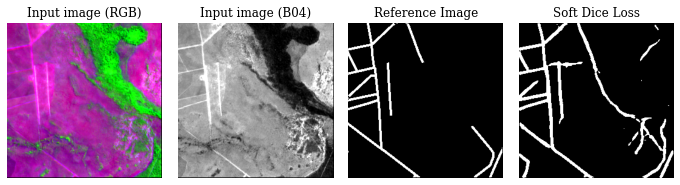

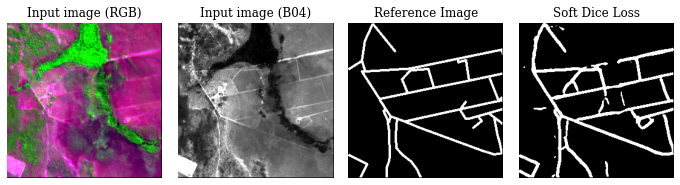

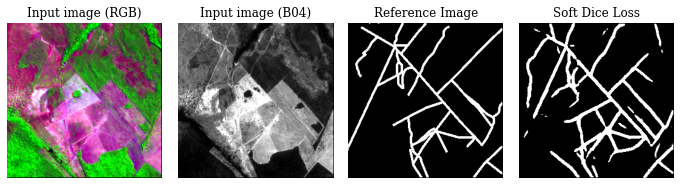

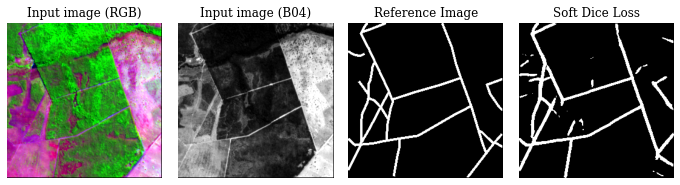

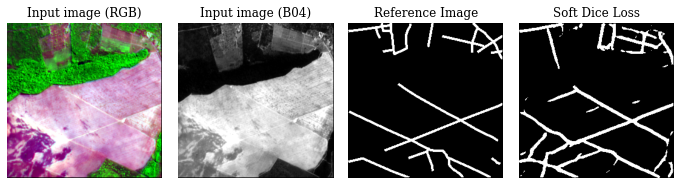

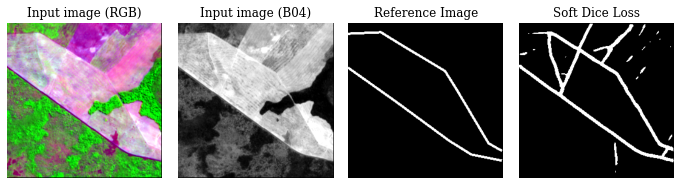

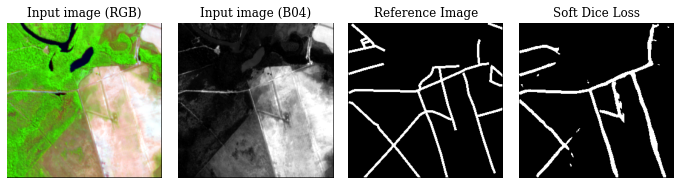

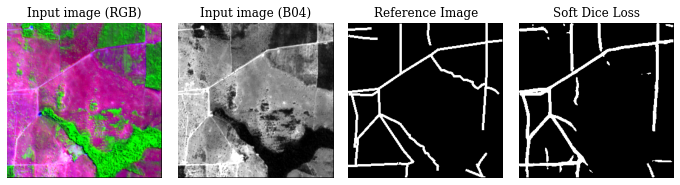

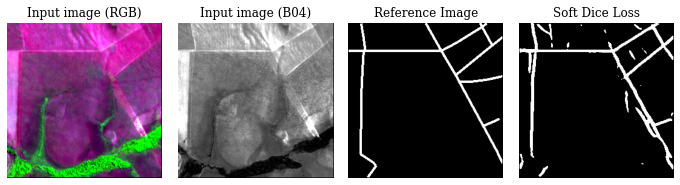

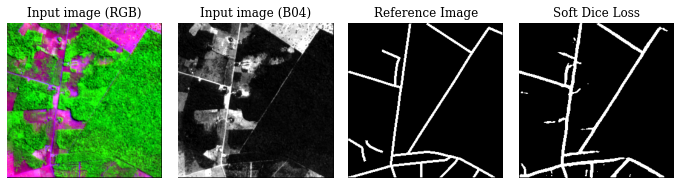

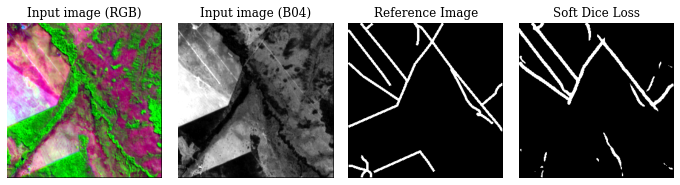

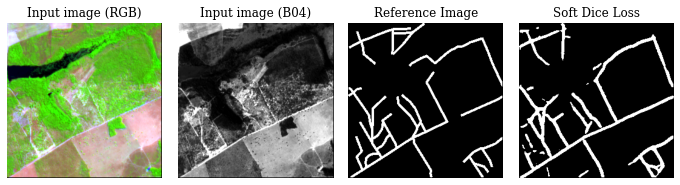

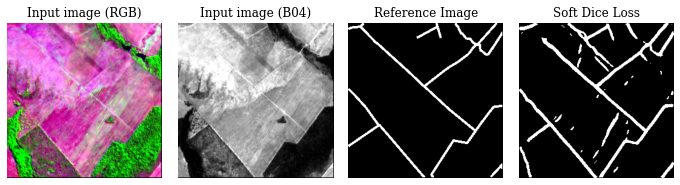

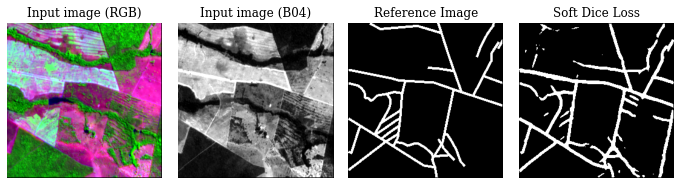

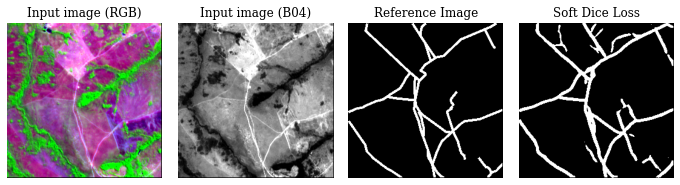

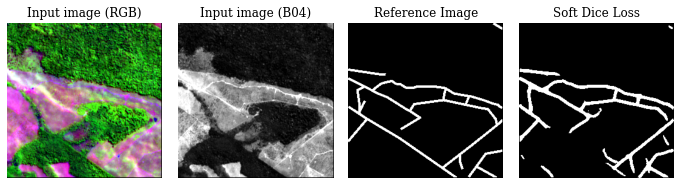

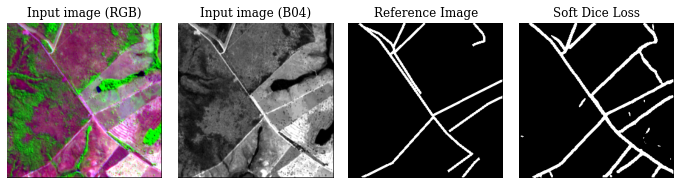

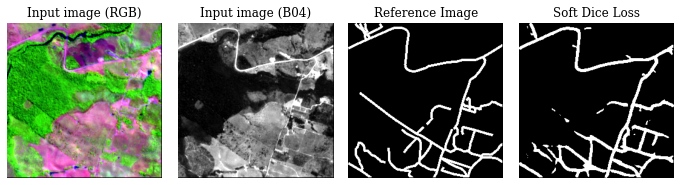

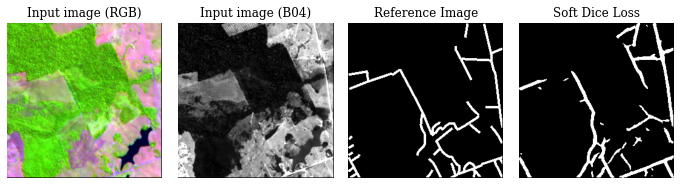

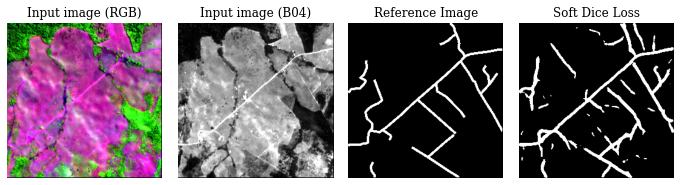

In [9]:
import tensorflow.keras.preprocessing as prep
from skimage.morphology import skeletonize, binary_closing
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.display import display

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
}

for x in range(30,50):
    fig = plt.figure(figsize=(15,15))

    gs = GridSpec(1, 5, figure=fig)
    gs.update(wspace=0.1, hspace=0.02)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[0, 3])
#     ax5 = fig.add_subplot(gs[0, 4])


    for i in test_set.skip(x).take(1):
        
        img_original = prep.image.array_to_img(i[0])
        ax1.imshow(img_original)
        ax1.axis('off')
        ax1.set_title("Input image (RGB)", fontdict=font)
        
        img_original = prep.image.array_to_img(i[0])
        ax2.imshow(img_original.split()[2], cmap=plt.cm.gray)
        ax2.axis('off')
        ax2.set_title("Input image (B04)", fontdict=font)

        img = prep.image.array_to_img(i[1])
        ax3.imshow(img, cmap=plt.cm.gray)
        ax3.axis('off')
        ax3.set_title("Reference Image", fontdict=font)


    predicted_soft_dice_1 = best_model_soft_dice.predict(test_set.skip(x).take(1).batch(1))

    predicted_soft_dice_1[predicted_soft_dice_1 < 0.2] = 0
    predicted_soft_dice_1[predicted_soft_dice_1 > 0.2] = 1
    predicted_soft_dice_1 = prep.image.array_to_img(predicted_soft_dice_1[0])

    ax4.imshow(predicted_soft_dice_1, cmap=plt.cm.gray)
    ax4.axis('off')
    ax4.set_title("Soft Dice Loss", fontdict=font)